In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import json
import shap

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
pd.set_option('display.max_columns', 50)
df = pd.read_csv('Datasets/heart_new.csv')

In [4]:
model_results = []
saves_dir = "Saves/"

cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [7]:
y = df['target']
X = pd.get_dummies(df.drop('target', axis=1), columns=cat_cols)

ss = StandardScaler()
ss.fit(X[num_cols])

X[num_cols] = ss.transform(X[num_cols])

In [8]:
df_explained = df.copy()
df_explained.loc[df['sex']==0, 'sex'] = 'female'
df_explained.loc[df['sex']==1, 'sex'] = 'male'

df_explained.loc[df['cp']==0, 'cp'] = 'typical_angina'
df_explained.loc[df['cp']==1, 'cp'] = 'atypical_angina'
df_explained.loc[df['cp']==2, 'cp'] = 'non_anginal_pain'
df_explained.loc[df['cp']==3, 'cp'] = 'asymptomatic'

df_explained.loc[df['restecg']==0, 'restecg'] = 'normal'
df_explained.loc[df['restecg']==1, 'restecg'] = 'st_t_wave_abnormality'
df_explained.loc[df['restecg']==2, 'restecg'] = 'left_ventricular_hypertrophy'

df_explained.loc[df['slope']==0, 'slope'] = 'upsloping'
df_explained.loc[df['slope']==1, 'slope'] = 'flat'
df_explained.loc[df['slope']==2, 'slope'] = 'downsloping'

df_explained.loc[df['thal']==0, 'thal'] = 'na'
df_explained.loc[df['thal']==1, 'thal'] = 'fixed_defect'
df_explained.loc[df['thal']==2, 'thal'] = 'normal'
df_explained.loc[df['thal']==3, 'thal'] = 'reversible_defect'

df_explained = pd.get_dummies(df_explained, columns=cat_cols)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.285, shuffle=True, random_state=42)

In [8]:
nb = GaussianNB()
nb.fit(X_train, y_train)

model_results.append(['Naive Bayes', nb.score(X_train, y_train), nb.score(X_test, y_test), ""])

joblib.dump(nb, saves_dir + 'naive_bayes.model')

['Saves/naive_bayes.model']

In [9]:
lr = LogisticRegression()
params_grid = {
    'C' : np.logspace(-4, 4)
}
cv = GridSearchCV(lr, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['Logistic Regression', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "C = " + str(round(cv.best_params_['C'],2))])

joblib.dump(cv.best_estimator_, saves_dir + 'logistic_regression.model')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.9s finished


['Saves/logistic_regression.model']

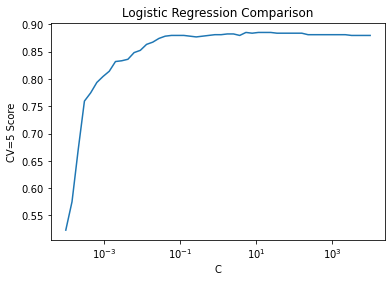

In [10]:
plt.semilogx(np.logspace(-4, 4), cv.cv_results_['mean_test_score'])
plt.title("Logistic Regression Comparison")
plt.xlabel("C")
plt.ylabel("CV=5 Score")
plt.savefig('Figures/log_comp.svg')
plt.show()

In [11]:
rc = RidgeClassifier()

params_grid = {
    'alpha': np.logspace(-9, 3)
}
cv = GridSearchCV(rc, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['Ridge Regression', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "alpha = " + str(round(cv.best_params_['alpha'], 5))])

joblib.dump(cv.best_estimator_, saves_dir + 'ridge_regression.model')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.3s finished


['Saves/ridge_regression.model']

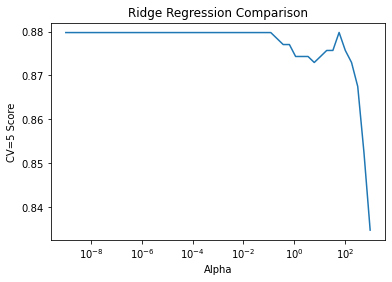

In [12]:
plt.semilogx(np.logspace(-9, 3), cv.cv_results_['mean_test_score'])
plt.title("Ridge Regression Comparison")
plt.xlabel("Alpha")
plt.ylabel("CV=5 Score")
plt.savefig('Figures/ridge_comp.svg')
plt.show()

In [13]:
knn = KNeighborsClassifier()
params_grid = {
    'n_neighbors': range(1,30)
}
cv = GridSearchCV(knn, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['K-Neighbors', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "n_neighbors = " + str(cv.best_params_['n_neighbors'])])

joblib.dump(cv.best_estimator_, saves_dir + 'k_neighbors.model')

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    0.4s finished


['Saves/k_neighbors.model']

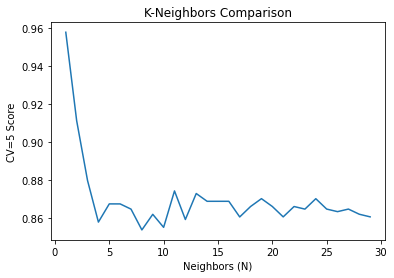

In [14]:
plt.plot(range(1,30), cv.cv_results_['mean_test_score'])
plt.title("K-Neighbors Comparison")
plt.xlabel("Neighbors (N)")
plt.ylabel("CV=5 Score")
plt.savefig('Figures/knn_comp.svg')
plt.show()

In [ ]:
svc = SVC()
params_grid = {
    'C' : np.logspace(-4, 4, 9),
    'gamma' : np.logspace(-4, 4, 9),
    'kernel' : ['poly'],
    'degree' : range(2,7)
}
cv = GridSearchCV(svc, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['SVM', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "C = " + str(cv.best_params_['C'])])

joblib.dump(cv.best_estimator_, saves_dir + 'svm.model')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


In [16]:
sgd = SGDClassifier(random_state=43)

params_grid = {
    'alpha': np.logspace(-3, 0, 200),
}
cv = GridSearchCV(sgd, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['Stochastic Gradient Descent', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "alpha = " + str(round(cv.best_params_['alpha'], 5))])

joblib.dump(cv.best_estimator_, saves_dir + 'sgd.model')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.0s finished


['Saves/sgd.model']

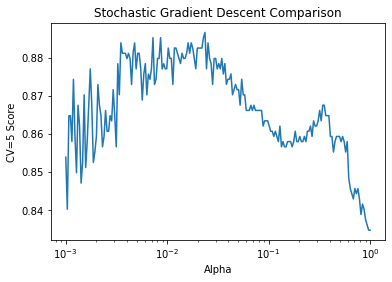

In [17]:
plt.semilogx(np.logspace(-3, 0, 200), cv.cv_results_['mean_test_score'])
plt.title("Stochastic Gradient Descent Comparison")
plt.xlabel("Alpha")
plt.ylabel("CV=5 Score")
plt.savefig('Figures/sgd_comp.svg')
plt.show()

In [20]:
dtc = DecisionTreeClassifier(random_state=42)
params_grid = {
      "criterion" : ["gini", "entropy"], 
      "splitter" : ["best", "random"], 
      "max_depth" : range(1,20), 
      "min_samples_split" : range(2, 5), 
      "min_samples_leaf" : range(1, 20)
}

cv = GridSearchCV(dtc, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['Decision Trees', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "max_depth = " + str(cv.best_params_['max_depth'])])

joblib.dump(cv.best_estimator_, saves_dir + 'decision_trees.model')

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 21209 tasks      | elapsed:   15.7s


0.9692832764505119


[Parallel(n_jobs=-1)]: Done 21660 out of 21660 | elapsed:   16.1s finished


['Saves/decision_trees.model']

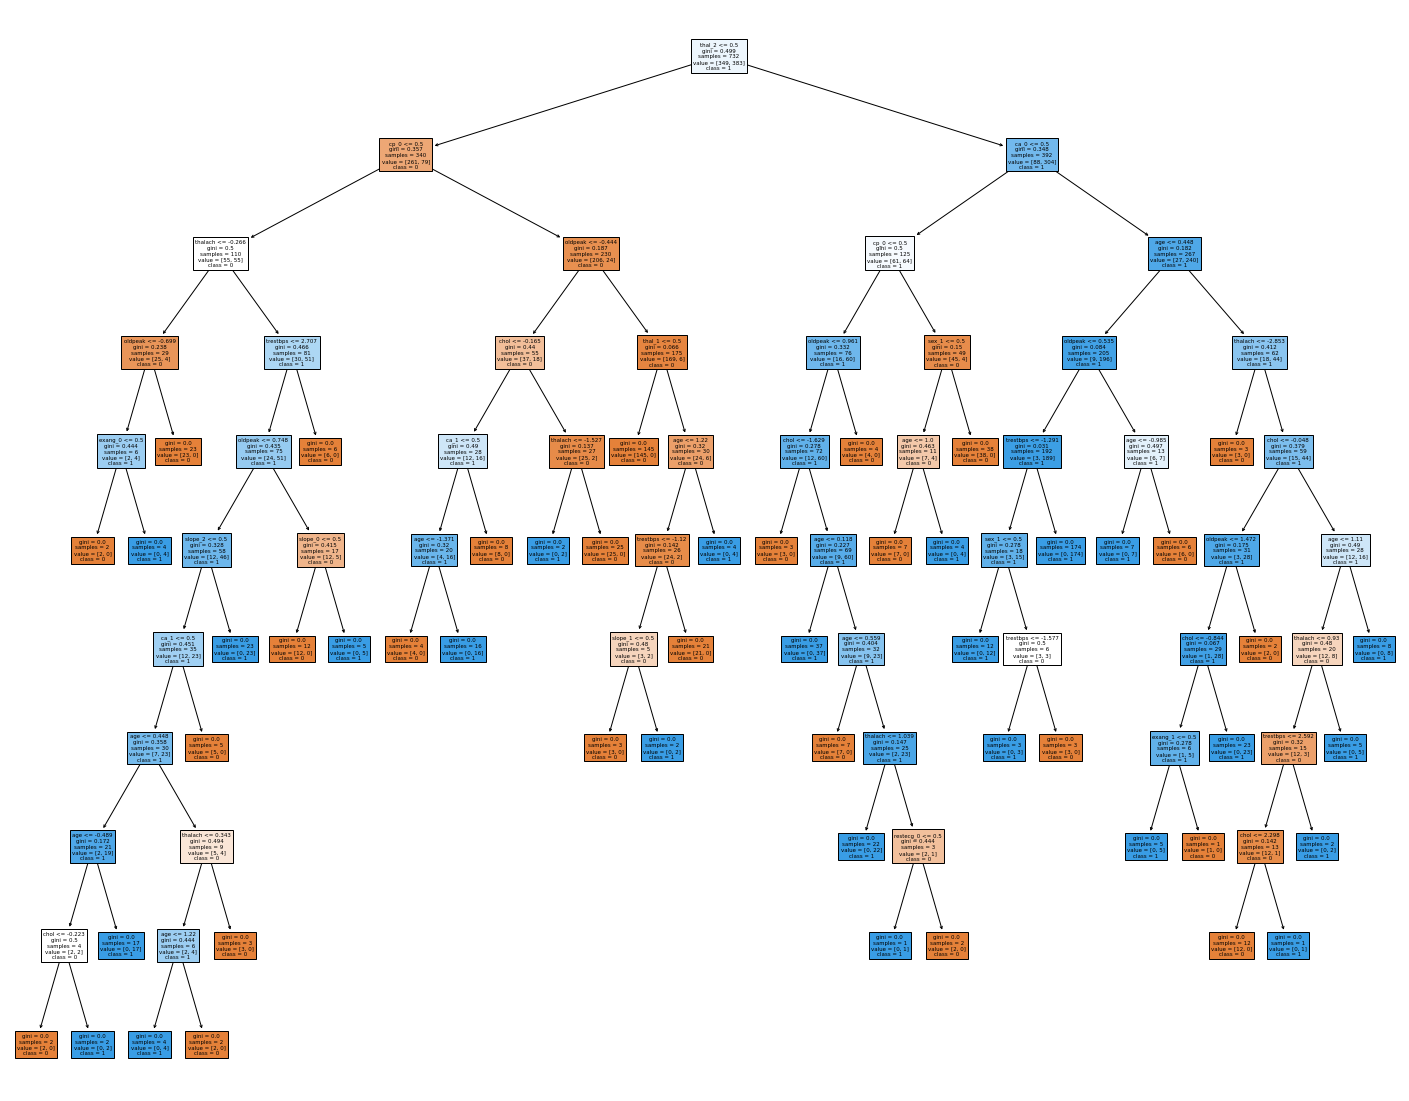

In [35]:
plt.figure(figsize=(25,20))
plot_tree(cv.best_estimator_, feature_names=X.columns,  class_names=['0', '1'], filled=True)
plt.savefig('Figures/dct.svg')
plt.show()

In [19]:
rf = RandomForestClassifier(random_state=42)
params_grid = {
    'n_estimators': range(10,300,10),
}

cv = GridSearchCV(rf, params_grid, n_jobs=-1, cv=5, verbose=1)
cv.fit(X_train, y_train)

model_results.append(['Random Forests', cv.best_score_, cv.best_estimator_.score(X_test, y_test), "n_estimators = " + str(cv.best_params_['n_estimators'])])

joblib.dump(cv.best_estimator_, saves_dir + 'random_forests.model')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 122 out of 145 | elapsed:    5.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    6.5s finished


['Saves/random_forests.model']

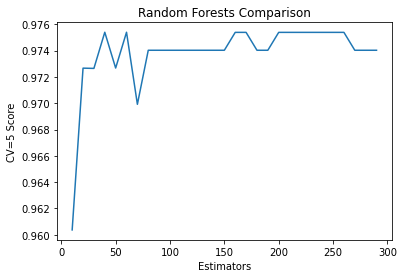

In [20]:
plt.plot(range(10,300,10), cv.cv_results_['mean_test_score'])
plt.title("Random Forests Comparison")
plt.xlabel("Estimators")
plt.ylabel("CV=5 Score")
plt.savefig('Figures/rf_comp.svg')
plt.show()

In [21]:
results = pd.DataFrame(model_results, columns=['Algorithm', 'Train Accuracy (%)', 'Test Accuracy (%)', 'Best Parameters'])

results.loc[:][['Train Accuracy (%)', 'Test Accuracy (%)']] = results.loc[:][['Train Accuracy (%)', 'Test Accuracy (%)']]  * 100

results = results.round({'Train Accuracy (%)' : 2, 'Test Accuracy (%)' : 2})

In [22]:
results

,Algorithm,Train Accuracy (%),Test Accuracy (%),Best Parameters
0,Naive Bayes,81.69,77.82,
1,Logistic Regression,88.52,80.89,C = 5.43
2,Ridge Regression,87.98,83.62,alpha = 59.63623
3,K-Neighbors,95.77,98.98,n_neighbors = 1
4,SVM,96.72,98.98,C = 0.0001
5,Stochastic Gradient Descent,88.66,81.91,alpha = 0.02354
6,Decision Trees,96.31,96.93,max_depth = 11
7,Random Forests,97.54,98.98,n_estimators = 40


In [23]:
results.to_csv('results.csv', index=False)

In [24]:
export_params = {
    'cat_cols' : cat_cols,
    'num_cols' : num_cols,
    'ss_mean' : ss.mean_.tolist(),
    'ss_std' : np.sqrt(ss.var_).tolist(),
    'cols' : X.columns.tolist()
}

In [25]:
with open("params.json", "w") as fp:
    fp.write(json.dumps(export_params))

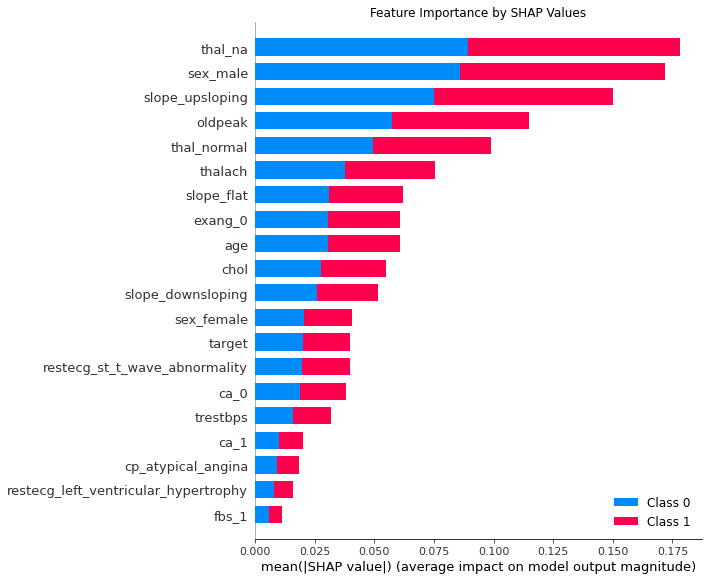

In [26]:
explainer = shap.TreeExplainer(cv.best_estimator_)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names = df_explained.columns, show=False)
plt.title("Feature Importance by SHAP Values")
plt.savefig('Figures/feature_importance.svg')

In [27]:
best_features = []
best_features_comp = []
for i in range(3,14):
    y = df['target']
    X = df.drop('target', axis=1)
    feat_select = SelectKBest(chi2, k=i)
    feat_select.fit(X, y)
    X_new = pd.DataFrame(feat_select.transform(X), columns=X.columns[feat_select.get_support()])

    num_cols_new = [col for col in X_new.columns if col in num_cols]
    cat_cols_new = [col for col in X_new.columns if col in cat_cols]

    ss = StandardScaler()
    ss.fit(X_new[num_cols_new])


    X_new[num_cols_new] = ss.transform(X_new[num_cols_new])
    
    X = pd.get_dummies(X_new, columns=cat_cols_new)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.285, shuffle=True, random_state=42)
    
    knn = KNeighborsClassifier()
    params_grid = {
        'n_neighbors': range(1,30)
    }
    
    cv = GridSearchCV(knn, params_grid, n_jobs=-1, cv=5, verbose=0)
    cv.fit(X_train, y_train)
    best_features.append([cv.best_score_,cv.best_estimator_.score(X_test, y_test)])
    
best_idx = np.argmax(np.array(best_features)) // 2
best_features_comp.append(["KNN All"] + (np.round(np.array(best_features[best_idx])*100,2)).tolist() + [best_idx + 3])

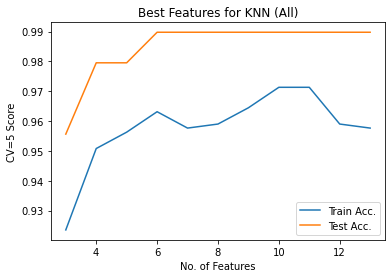

In [28]:
plt.plot(range(3,14), best_features)
plt.title("Best Features for KNN (All)")
plt.xlabel("No. of Features")
plt.ylabel("CV=5 Score")
plt.legend(["Train Acc.", "Test Acc."])
plt.savefig('Figures/best_feat_all.svg')
plt.show()

In [29]:
best_features = []
for i in range(1,9):
    y = df['target']
    X = df[cat_cols]
    feat_select = SelectKBest(chi2, k=i)
    feat_select.fit(X, y)
    X_new = pd.DataFrame(feat_select.transform(X), columns=X.columns[feat_select.get_support()])

    cat_cols_new = [col for col in X_new.columns if col in cat_cols]

    X = pd.get_dummies(X_new, columns=cat_cols_new)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.285, shuffle=True, random_state=42)
    
    knn = KNeighborsClassifier()
    params_grid = {
        'n_neighbors': range(1,30)
    }
    
    cv = GridSearchCV(knn, params_grid, n_jobs=-1, cv=5, verbose=0)
    cv.fit(X_train, y_train)
    best_features.append([cv.best_score_,cv.best_estimator_.score(X_test, y_test)])
    
best_idx = np.argmax(np.array(best_features)) // 2
best_features_comp.append(["KNN Categorical Only"] + (np.round(np.array(best_features[best_idx])*100,2)).tolist() + [best_idx + 1])

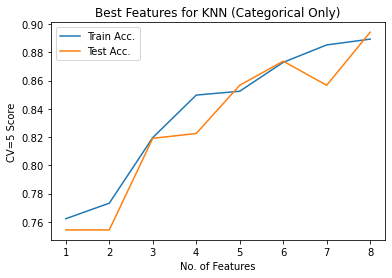

In [30]:
plt.plot(range(1,9), best_features)
plt.title("Best Features for KNN (Categorical Only)")
plt.xlabel("No. of Features")
plt.ylabel("CV=5 Score")
plt.legend(["Train Acc.", "Test Acc."])
plt.savefig('Figures/best_feat_cat.svg')
plt.show()

In [31]:
best_features = []
for i in range(1,6):
    y = df['target']
    X = df[num_cols]
    feat_select = SelectKBest(chi2, k=i)
    feat_select.fit(X, y)
    X_new = pd.DataFrame(feat_select.transform(X), columns=X.columns[feat_select.get_support()])

    num_cols_new = [col for col in X_new.columns if col in num_cols]

    ss = StandardScaler()
    ss.fit(X_new[num_cols_new])


    X_new[num_cols_new] = ss.transform(X_new[num_cols_new])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.285, shuffle=True, random_state=42)
    
    knn = KNeighborsClassifier()
    params_grid = {
        'n_neighbors': range(1,30)
    }
    
    cv = GridSearchCV(knn, params_grid, n_jobs=-1, cv=5, verbose=0)
    cv.fit(X_train, y_train)
    best_features.append([cv.best_score_,cv.best_estimator_.score(X_test, y_test)])
    
best_idx = np.argmax(np.array(best_features)) // 2
best_features_comp.append(["KNN Numerical Only"] + (np.round(np.array(best_features[best_idx])*100,2)).tolist() + [best_idx + 1])

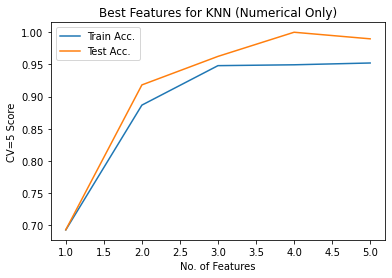

In [32]:
plt.plot(range(1,6), best_features)
plt.title("Best Features for KNN (Numerical Only)")
plt.xlabel("No. of Features")
plt.ylabel("CV=5 Score")
plt.legend(["Train Acc.", "Test Acc."])
plt.savefig('Figures/best_feat_num.svg')
plt.show()

In [33]:
best_feat_results = pd.DataFrame(best_features_comp, columns=['Features Type', 'Training Accuracy (%)', 'Testing Accuracy (%)', 'No. of Features Kept'])
best_feat_results

,Features Type,Training Accuracy (%),Testing Accuracy (%),No. of Features Kept
0,KNN All,96.31,98.98,6
1,KNN Categorical Only,88.93,89.42,8
2,KNN Numerical Only,94.94,100.00,4


In [34]:
best_feat_results.to_csv('best_feat_results.csv', index=False)